In [1]:
ls

Deribit_Options_BTC.tsv  Kraken_ethusd.tsv        notebooks/
Deribit_Options_ETH.tsv  collector/
Dockerfile               ethusd.ipynb


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

In [3]:
df = pd.read_csv('Kraken_ethusd.tsv', sep='\t', names = ['time', 'price', 'volume'], index_col = False)

In [4]:
df['minute'] = df.time.apply(lambda x: x[:16])

In [6]:
df.head()

,time,price,volume,minute
0,2017-11-06 20:27:33.000000,302.49,0.990181,2017-11-06 20:27
1,2017-11-06 20:27:33.000000,302.50,0.434819,2017-11-06 20:27
2,2017-11-06 20:27:41.000000,302.50,0.186500,2017-11-06 20:27
3,2017-11-06 20:27:41.000000,302.50,0.813500,2017-11-06 20:27
4,2017-11-06 20:27:41.000000,301.33,1.244500,2017-11-06 20:27


In [7]:
df = df.drop(['time'], axis=1)

In [8]:
d = df.groupby('minute').tail(1)

In [9]:
d.tail()

,price,volume,minute
10404834,239.01,7.750000e+00,2020-03-07 17:58
10404847,239.35,7.000000e-01,2020-03-07 17:59
10404894,238.41,2.200000e-07,2020-03-07 18:00
10404919,238.75,9.519000e+00,2020-03-07 18:01
10404999,238.19,6.680000e+00,2020-03-07 18:02


Надо взять статистику за 20год

In [220]:
s = '2020'
a = d[d['minute'].str.contains(s)]['price'].diff()

# Нормальное распределение

я взял частное !!

In [92]:
a = df['price'].diff()

In [14]:
s='2020'
a = d[d['minute'].str.contains(s)]['price'].values
a = a[1:]/a[:-1]

In [15]:
a.max(), a.min()

(1.0179032853451457, 0.9794039518212583)

In [17]:
norm_mean, norm_std = a.mean(), a.std()

In [18]:
def std_norm(a):
    m = a.mean()
    d = np.sum((a-m)**2)/(len(a)-1)
    return np.sqrt(d)

In [19]:
def custom_normal(l, mean=0, std=1):
    u1 = np.random.uniform(size=l)
    u2 = np.random.uniform(size=l)
    R_sq = -2 * np.log(u1)
    theta = 2 * np.pi * u2
    z1 = np.sqrt(R_sq) * np.cos(theta)
    return z1*std + mean

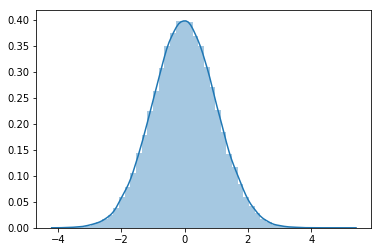

In [20]:
sns.distplot(custom_normal(len(a)))

In [21]:
std_norm(a)

0.001436498992480846

In [22]:
norm_mean, norm_std

(1.0000098995683708, 0.0014364886513716325)

In [23]:
a = a[1:]
a.shape

(69455,)

применим z стандартизацию наших данных

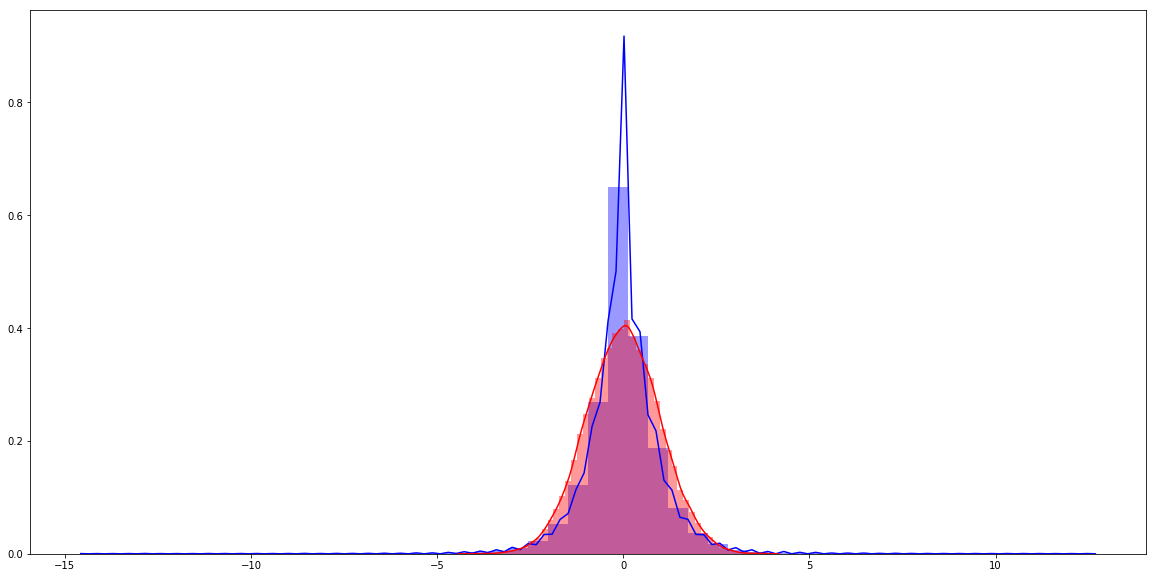

In [24]:
normal = np.random.normal(size=a.shape)
plt.figure(figsize=(20,10))
sns.distplot((a-norm_mean)/norm_std, color='blue')
sns.distplot(normal,  color='red')

у нормального распрелеления 68% наблюдений +- sigma

In [130]:
np.percentile(normal, 16), np.percentile(normal, 84)

(-0.9943304273566551, 0.9951416972641973)

In [132]:
np.percentile((a-norm_mean)/norm_std, 16), np.percentile((a-norm_mean)/norm_std, 84)

(-0.07295291743918068, 0.05473441488452885)

# логнормальное распределение

In [36]:
norm_std, norm_mean

(0.0014364886513716325, 1.0000098995683708)

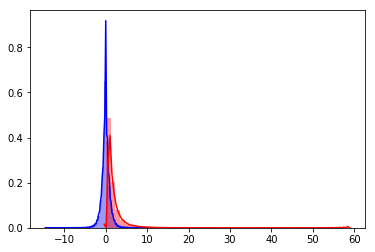

In [40]:
lognormal = np.random.lognormal(size=a.shape)
sns.distplot((a-norm_mean)/norm_std, color='blue')
sns.distplot(lognormal,  color='red')

In [153]:
np.percentile(lognormal, 16), np.percentile(lognormal, 84)

(0.3696027499667139, 2.70191978600085)

In [168]:
log_mean, log_std

(6.381301575732997e+106, 2.5835248642666387e+107)

используя преобразование бокса мюллера, мы можем получить логнормальное распределние с нужными параметрами

In [212]:
def mean_convert(m, std):
    return np.exp(m+std/2)
def std_convert(m,std):
    return np.exp(2*m+std)*(np.exp(std)-1)

# Логнормальное распределение от 0 до инф, соответственно можно говорить только о моделировании квадрата(модуля) изменения цены.
немного лучше моделирует логнормальное, но тоже херово

взято из википедии. формула геометрического броуновского движения

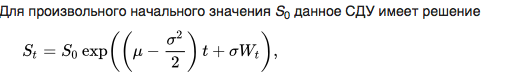

где 

моя мысль такая. Если мы счиатем, что распределение со временем не меняется, то зная распределение за 6 месяцев, мы можем построить распределение за след месяц, уменьшив количество наблюдений в 6 раз. 

In [41]:
a.mean(), a.std()

(1.0000099109014917, 0.001436495887392505)

Если тупо поставить в формулу какой то временной шаг, то будет что то подобное

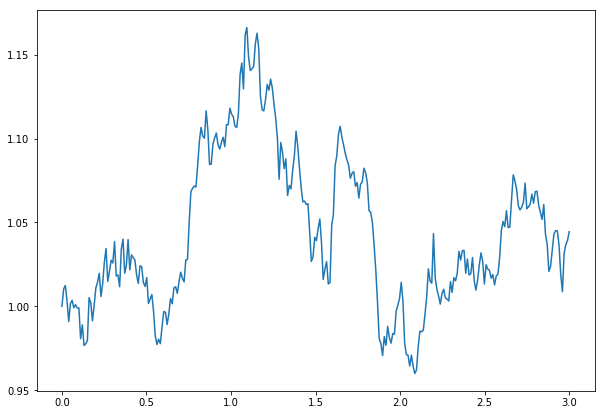

In [147]:
T = 3
mu = 0
sigma = 0.1
dt = 0.01
N = round(T/dt)
t = np.linspace(0, T, N)

X = np.random.normal(mu * dt, sigma* np.sqrt(dt), N)
S = np.exp(np.cumsum(X))
plt.figure(figsize=(10,7))
plt.plot(t, S)
plt.show()

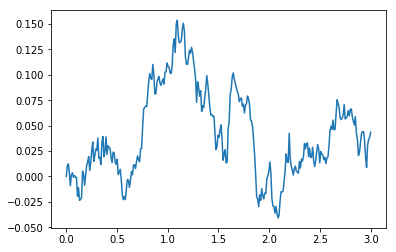

In [148]:
plt.plot(t, np.cumsum(X))
plt.show()

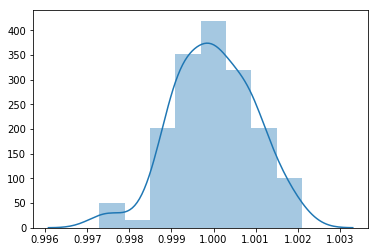

In [131]:
sns.distplot(S[1:]/S[:-1])

![alt text](black.png "Title")

In [132]:
from scipy.stats import norm

def BlackScholesCall(S,X,T,r,v):

    d1 = (np.log(S/X)+(r+v*v/2.)*T)/(v*np.sqrt(T))
    d2 = d1-v*np.sqrt(T)
    P = S*norm.cdf(d1) - X*np.exp(-r*T)*norm.cdf(d2)
    return P

def BlackScholesPut(S,X,T,r,v):

    d1 = (np.log(S/X)+(r+v*v/2.)*T)/(v*np.sqrt(T))
    d2 = d1-v*np.sqrt(T)
    P = -S*norm.cdf(-d1) + X*np.exp(-r*T)*norm.cdf(-d2)
    return P

In [109]:
def CallExpiry(S,X):
    return max(S-X, 0)

In [137]:
S_array = np.linspace(0,10,1000)
P = [BlackScholesCall(float(S), 8, 0.2, 0.1, 0.3) for S in S_array]
E = [CallExpiry(float(S), 8) for S in S_array]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


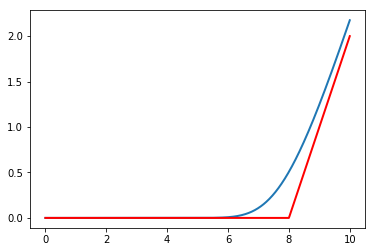

In [138]:
plt.plot(S_array, P, lw=2)
plt.plot(S_array, E, 'r-', lw=2)

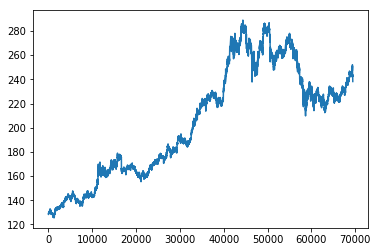

In [154]:
val = d[d['minute'].str.contains(s)]['price'].values
plt.plot(val)

In [155]:
val.mean(), val.std()

(204.72565227406884, 46.00356167991527)

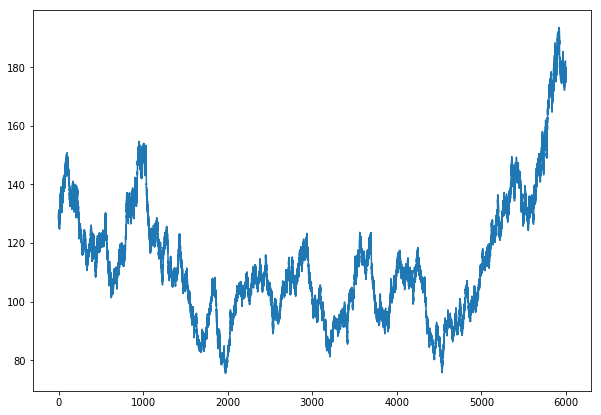

In [159]:
T = 6000
mu = 0
sigma = 0.01
dt = 0.01
N = round(T/dt)
t = np.linspace(0, T, N)
S0=129
X = np.random.normal(mu * dt, sigma* np.sqrt(dt), N)
S = S0*np.exp(np.cumsum(X))
plt.figure(figsize=(10,7))
plt.plot(t, S)
plt.show()